# 敏感度

```{admonition} 学习目标
阅读本章后，您将能够：
- 定义敏感度
- 找到计数问询的敏感度
- 找到求和问询的敏感度
- 将均值问询分解为计数问询和求和问询
- 使用裁剪技术限制求和问询的敏感度上界
```

我们在讲解拉普拉斯机制时曾提到，使问询满足差分隐私所需的噪声量取决于问询的*敏感度*。简单来说，函数的敏感度反应了函数输入发生变化时对应输出的变化程度。回想一下，拉普拉斯机制定义了下述机制$F(x)$：

\begin{align}
F(x) = f(x) + \textsf{Lap}\left(\frac{s}{\epsilon}\right)
\end{align}

其中$f(x)$（即问询函数）是确定性函数，$\epsilon$是隐私参数，而$s$就是$f$的敏感度。

给定一个将数据集（$\mathcal{D}$）映射为实数的函数$f : \mathcal{D} \rightarrow \mathbb{R}$，$f$的*全局敏感度*（Global Sensitivity）定义如下：

```{prf:definition} Global Sensitivity
:label: global-sensitivity
\begin{align*}
GS(f) = \max_{x, x': d(x,x') <= 1} |f(x) - f(x')|
\end{align*}
```

其中$d(x, x')$表示两个数据集$x$和$x'$之间的*距离*（Distance）。如果两个数据集之间的距离小于等于1，我们称这两个数据集是*临近集*（Neighbor）。数据集的距离定义会对隐私定义带来很大的影响。我们稍后将讨论如何度量数据集之间的距离。

全局敏感度的定义告诉我们，对于*任意两个*临近数据集$x$和$x'$，函数$f(x)$和$f(x')$的输出最多相差$GS(f)$。此敏感度的定义与具体问询的数据集无关（对于*任意*两个临近集$x$和$x'$都成立），因此我们把这一敏感度度量方法称为"全局"敏感度。另一种敏感度度量方法将其中一个数据集固定为被问询的数据集，对应的敏感度称为*局部敏感度*（Local Sensitivity）。我们将在稍后的章节中具体讨论局部敏感度。现在，当提到"敏感度"时，我们均指全局敏感度。

## 距离

可以用很多不同的方法来度量前面提到的距离$d(x,x')$。直观来看，如果两个数据集中只有一个个体的数据不一样，则这两个数据集之间的距离应该等于1（即这两个数据集是临近集）。很容易在某些场景下用数学语言定义距离度量方法（例如，在美国人口普查场景中，每个个体都只贡献一条自己的数据）。但在另一些场景下（如位置轨迹、社交网络、时序数据等场景），用数学语言定义距离度量方法颇具挑战。

对于按行存储的数据集，通常会把距离定义为有多少行数据值不相同。当每一行仅包含单一个体的数据时，此种距离度量方法一般都是合理的。如果用数学语言描述，此距离度量方法可以由两个数据集的*对称差*（Symmetric Difference）所定义：

```{prf:definition} Symmetric Difference
:label: symmetric-difference
\begin{align*}
d(x, x') = | x - x' \cup x' - x |
\end{align*}
```

这个特殊定义有几个有趣且重要的含义：
- 如果$x'$是通过向$x$*添加一行*来构造的，则$d(x,x') = 1$
- 如果$x'$是通过从$x$*删除一行*来构造的，则$d(x,x') = 1$
- 如果$x'$是通过在$x$*修改一行*来构造的，则$d(x,x') = 2$

换句话说，添加或删除一行数据可以生成相邻数据集；*修改*一行数据则生成距离为*2*的数据集。

这种对距离的特殊定义通常称为*无界差分隐私（Unbounded Differential Privacy）*。也有一些其他的距离定义。例如，*有界差分隐私（Bounded Differential Privacy）*认为修改数据集中的单行数据*即可*构成临近数据集。

现在，我们主要采用对称差临近数据集的数学定义。我们将在稍后的章节中讨论替代定义。

## 计算敏感度

我们如何确定特定函数的敏感度呢？对于实数域上的一些简单函数，答案是显而易见的。

- $f(x) = x$的全局敏感度是1，因为$x$变化1，$f(x)$变化为1
- $f(x) = x+x$的全局敏感度是2，因为$x$变化1，$f(x)$变化为2
- $f(x) = 5*x$的全局敏感度是5，因为$x$变化1，$f(x)$变化为5
- $f(x) = x*x$的全局敏感度是无界的，因为$f(x)$的变化取决于$x$的值

对于将数据集映射到实数的函数，我们都采用类似的分析方法。我们下面将考虑3个常见的数据库聚合问询函数:计数问询、求和问询、均值问询。

In [13]:
import pandas as pd
import numpy as np
!mplfonts init
import matplotlib.pyplot as plt
from mplfonts import use_font
use_font('SimHei')

adult = pd.read_csv("adult_with_pii.csv")

### 计数问询

计数问询（数据库SQL中的`COUNT`算子）计算数据集中满足特定属性的行数。一般来说，**计数问询的敏感度总等于1**。这是因为向数据集中添加一行数据最多会使问询的输出结果增加1，即当新增行满足特定属性时，计数结果加1。反之，当新增行不满足特定属性时，计数结果不变（删除行可能使计数结果减1）。

**例子："数据集中有多少人？"**（敏感度：1，计算总行数）

In [14]:
adult.shape[0]

32563

**例子："受教育年数超过10年的有多少人"**（敏感度：1，根据属性计算行数）

In [15]:
adult[adult['Education-Num'] > 10].shape[0]

10517

**例子："受教育年数小于或等于10年的有多少人？"**（敏感度：1，根据属性计算行数）

In [16]:
adult[adult['Education-Num'] <= 10].shape[0]

22046

**例子："名字叫Joe Near的有多少人？"**（敏感度：1，根据属性计算行数）

In [17]:
adult[adult['Name'] == 'Joe Near'].shape[0]

0

### 求和问询

求和问询（数据库SQL中的`SUM`算子）计算数据集行中的*属性值（Attribute Values）* 总和。

**例子："受教育年数超过10年的人，其年龄总和是多少？"**

In [18]:
adult[adult['Education-Num'] > 10]['Age'].sum()

441431

计算求和问询的敏感度不像计数问询那么简单。向数据集添加一行新数据会使样例问询增加*一个新个体的年龄*。这意味着问询的敏感度取决于我们添加的*具体数据*是什么。

我们想要用一个确定的数来表示求和问询的敏感度。不幸的是，这样的数并不存在。例如，我们可以把敏感度直接设置为125。但这意味着数据集新增行的年龄不能超过125岁，否则我们设置的敏感度就不满足敏感度的定义了。无论我们把敏感度设置为多少，新增行都可能和我们的敏感度设置冲突。

你可能对此结论持怀疑态度（可能是对的）。假设我们把敏感度设置为1000。我们几乎不可能找到一个年龄为1000岁的人来违背此敏感度。对于年龄这个特殊的属性来说，我们可以认为人的年龄有合理的上界。有史以来最长寿的人活到了[122岁](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people)，因此把敏感度设置为122岁这个上界看起来是合理的。

但这不能证明没有人能活到126岁。对于（收入等）其他属性，就很难找到一个合理的上界。

一般来说，当待求和的属性值不存在上界和下界时，我们称求和问询具有**无界敏感度**。当存在上下界时，求和问询的敏感度等于**上下界的差**。在下一节，我们将介绍*裁剪*（Clipping）技术。此技术用于在边界不存在时强制划定边界，以便将无界敏感度的求和问询转化为有界敏感度的问询。

### 均值问询

均值问询（数据库SQL中的`AVG`算子）计算指定列属性值的平均值。

**例子："受教育年数超过10年的人，其平均年龄是多少？"**

In [19]:
adult[adult['Education-Num'] > 10]['Age'].mean()

41.973091185699346

应用差分隐私回复均值问询的最简单方法是，将均值问询拆分为两个问询：求和问询除以计数问询。对上述例子，我们有：

In [20]:
adult[adult['Education-Num'] > 10]['Age'].sum() / adult[adult['Education-Num'] > 10]['Age'].shape[0]

41.973091185699346

求和问询和计数问询的敏感度都可以根据前面提到的方法计算得到。因此，我们可以分别计算两个问询的噪声回复（如使用拉普拉斯机制）。对两个噪声回复做除法，即可得到差分隐私均值。我们可以应用串行组合性计算两个问询的总隐私消耗量。

## 裁剪

差分隐私的拉普拉斯机制的无法直接应用于无界敏感度问询。幸运的是，我们通常可以利用*裁剪*（Clip）技术将此类问询转换为等价的*有界*敏感度问询。

裁剪技术的基本思想是，*强制*设置属性值的上界和下界。例如，125岁以上的年龄可以被"裁剪"到恰好125岁。经过裁剪后，所有年龄都肯定不超过125岁。因此，对裁剪数据执行求和问询的敏感度等于上下界的差：$上界 - 下界$。例如，以下问询的敏感度为125：

In [21]:
adult['Age'].clip(lower=0, upper=125).sum()

1360238

使用裁剪技术的主要挑战是确定属性值的上界和下界。很容易确定年龄的上下界：没有人的年龄会低于0，年龄很大概率也不会高于125岁。如前所述，确定其他属性值的上下界要困难得多。

此外，还需在裁剪造成的信息量损失和满足差分隐私所需的噪声间进行权衡。裁剪边界的上界和下界越接近，敏感度越低，差分隐私所需的噪声就越小。然而，过分裁剪经常会从数据中移除很多信息。这些信息的移除可能给准确度带来*损失*，超过更小敏感度改善噪声带来的准确度提升效果。

一般来说，**要将裁剪边界设置为（尽可能）100%的保留数据集的所有信息**。但必须承认，某些领域（例如后续将学习的图问询）很难做到这一点。

很容易想到通过查看数据来确定裁剪边界。例如，我们可以查看数据集的年龄直方图，从而确定一个适当的敏感度上界：

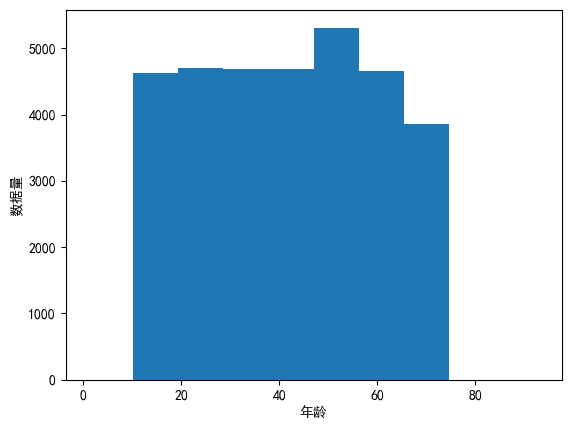

In [22]:
plt.hist(adult['Age'])
plt.xlabel('年龄')
plt.ylabel('数据量');

从直方图可以清晰地看出，这个特定数据集中没有人的年龄超过90岁，因此90的上界就足够了。

但请重点注意，**此方法并不满足差分隐私**。如果我们通过查看数据来选择裁剪边界，那么边界本身也可能会泄露数据的一些相关信息。

一般可以根据数据集先天满足的一些属性来确定裁剪边界。特别要注意，应该无需查看数据本身即可获得此属性（例如数据集包含年龄列，年龄取值范围很可能在0到125之间）。也可以应用差分隐私问询估计选择的边界是否恰当。

当使用第二种方法确定裁剪边界时，我们一般先将敏感度下界设置为0，随后逐渐增加上界，直至问询输出不再变化（也就是说，即使进一步提高上界，问询的数据也不会再因裁剪而发生任何变化）。例如，让我们尝试计算裁剪边界从0到100的年龄总和，并对每次问询使用拉普拉斯机制，保证此过程满足差分隐私：

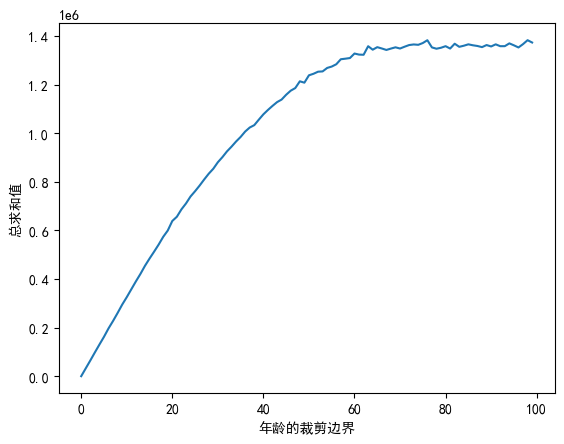

In [23]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

epsilon_i = .01
plt.plot([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)])
plt.xlabel('年龄的裁剪边界')
plt.ylabel('总求和值');

我们进行了100次$\epsilon_i = 0.01$的问询。因此，根据串行组合性，构建上图的总隐私消耗量为$\epsilon = 1$。显然，问询结果在`upper = 80`附近趋于平稳，把80作为裁剪边界是个不错的选择。

我们可以用相同的方法估计任意数值型属性列的边界，但估计前我们最好能提前知道数据的大致取值范围。例如，如果将年收入的边界值裁剪为0到100，裁剪边界的估计效果就不是很好，我们甚至无法找到合理的上界。

当数据的取值范围未知时，一种很好的改进方法就是根据依对数取值范围估计上界。

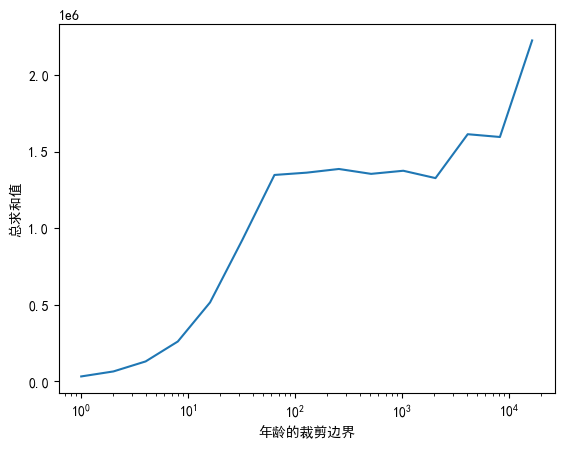

In [24]:
xs = [2**i for i in range(15)]
plt.plot(xs, [laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in xs])
plt.xscale('log')
plt.xlabel('年龄的裁剪边界')
plt.ylabel('总求和值');

这样一来，我们通过少量问询就可以测试大量可能的裁剪边界取值，但代价是很难准确地找到完美的裁剪边界。当上界的取值变得非常大时，噪声就会开始淹没信号了。在裁剪取值达到最大时，图中年龄求和结果波动得非常剧烈！关键是要在图中找到一个相对平滑（意味着噪声小）且求和结果不再增加（意味着裁剪边界足够大）的裁剪边界取值区域。在这个例子中，上界大约为$2^8 = 256$。这个结果相对比较合理，与我们前面推导出的年龄上界已经比较接近了。

## 避免低估敏感度

为了正确预测查询和转换的敏感度，我们依赖于对算术运算符等数值函数的数学推理。

如果由于某种原因，我们的数值函数未能按预期正常工作，这将影响我们的敏感度分析。例如，当发生整数溢出或浮点表示错误时，就可能出现这种情况 {cite}`mironov2012,under2022`。

In [25]:
0.1 + 0.2

0.30000000000000004

哦不！在这个例子中，由于Python中浮点数的表示误差，我们的结果比预期的稍大。

这意味着在任何简单地添加浮点数类型的Python数值操作中，都有可能低估敏感度。

幸运的是，有几种方法可以解决这个问题——在Python和其他编程语言中——例如通过截断和舍入，有几种技术。在许多情况下，这些技术在效率和精度之间进行权衡。

例如，在Python中，我们可以通过decimal模块实现任意精度，该模块支持快速且正确舍入的十进制浮点运算。

In [ ]:
from decimal import *

Decimal("0.1") + Decimal("0.2")

使用这种方法，我们可以获得正确的结果，并保持敏感度分析的正确性。

```{tip}
在Python3中，整数具有任意大小，[仅受可用内存的限制](https://docs.python.org/3/library/exceptions.html#OverflowError)。这意味着我们通常不需要担心整数溢出会影响敏感度分析的正确性。
```

敏感度低估可能会破坏差分隐私保证，而敏感度高估则会导致私有分析中的不必要不准确性。

```{admonition} Summary
- 确保给定查询的差分隐私所需的噪声量取决于查询的敏感度。
- 大致来说，函数的敏感度反映了当输入变化时，函数输出的变化量。
- 直观上，如果两个数据集在一个个体的数据上有所不同，那么它们之间的距离应等于1（即数据集是相邻的）。
- 对于具有无界敏感度的查询，无法直接使用拉普拉斯机制回答差分隐私问题。
- 幸运的是，我们通常可以通过称为剪辑的过程，将此类查询转换为具有有界敏感度的等效查询。
- 为了正确预测查询和转换的敏感度，我们依赖于对数值函数的数学推理。
- 敏感度低估可能会破坏差分隐私保证，而敏感度高估则会导致私有分析中的不必要不准确性。
```